<img src="https://upload.wikimedia.org/wikipedia/commons/f/ff/Uexternado.jpg" width="240" height="240" align="right"/>

# Modelos Supervisados

## Árboles

Andrés Martínez<br>
Julio 2024

# Árboles

Los clasificadores de árboles de decisión son modelos atractivos si nos preocupamos por la interpretabilidad. Como sugiere el nombre "árbol de decisiones", podemos pensar en este modelo como un desglose de nuestros datos al tomar una decisión basada en una serie de preguntas.

Usando el algoritmo de decisión, comenzamos en la raíz del árbol y dividimos los datos en la característica que da como resultado la mayor ganancia de información (IG), que se explicará con más detalle en la siguiente sección. En un proceso iterativo, podemos repetir este procedimiento de división en cada nodo secundario hasta que las hojas estén puras. Esto significa que todos los ejemplos de entrenamiento en cada nodo pertenecen a la misma clase. En la práctica, esto puede dar como resultado un árbol muy profundo con muchos nodos, lo que puede conducir fácilmente a un sobreajuste. Por lo tanto, normalmente queremos podar el árbol estableciendo un límite para la profundidad máxima del árbol.

<a><center> <img src='arbol.png'  width="400"/><center></a>




### Elementos de un árbol de desición.

***información de ganancia***

La información de ganancia nos ayuda a determinar el nivel de **impureza** de las ramas entre los **nodos** padres y los **nodos** hijos. 

$$IG(D_p , f)=I(D_p)-\sum_{j=1}^{m} \frac{N_j}{N_p}I(D_j)$$

Donde $f$ es el feature, $D_p$ son los datos de los nodos padres, $D_j$ los datos de los nodos hijos, $I$ es la medida de impureza. $N_p$ número total de datos de entrenamiento en el nodo padre y $N_j$ número de ejemplos en el nodo hijo.

La ganancia de información es simplemente la diferencia entre la impureza del nodo principal y la suma de las impurezas del nodo secundario: cuanto menor sea la impureza de los nodos secundarios, mayor será la ganancia de información.

## Construcción de un árbol de decisión

Construir un árbol de decisiones no es realmente mucho más difícil que leer uno. 

 * Si todos los datos tienen la misma etiqueta, cree un nodo hoja que prediga esa etiqueta y listo.
 * Si la lista de atributos está vacía (por ejemplo, porque ya ha usado todos), cree un nodo de hoja que prediga la etiqueta más común.
 * De lo contrario, divida los datos por cada uno de los atributos; elija la partición con el error más bajo.
 * Continuar recursivamente en cada subconjunto particionado usando los atributos restantes.
 * Terminar cuando no queden atributos (ver arriba), o cuando se alcance la profundidad deseada u otro criterio de terminación.


Los árboles de decisión son también los componentes fundamentales de los bosques aleatorios (Random Forest), que se encuentran entre los algoritmos de aprendizaje automático más potentes de la actualidad. 

Aquí  empezaremos por discutir cómo entrenar, visualizar y hacer predicciones con Árboles de Decisión. A continuación, repasaremos el algoritmo de entrenamiento CART utilizado por Scikit-Learn, y discutiremos cómo regularizar los árboles y utilizarlos para tareas de regresión. Por último, discutiremos algunas de las limitaciones de los árboles de decisión.

### Medidas de impureza


***Entropia***

$$I_H = -\sum_{i=1}^{c}p(i\mid t)\log_2 p(i\mid t)$$


Aquí, $p(i|t)$ es la proporción de los ejemplos que pertenecen a la clase $i$ para un nodo particular, $t$. Por lo tanto, la entropía es 0 si todos los ejemplos en un nodo pertenecen a la misma clase, y la entropía es máxima si tenemos una distribución de clases uniforme. Por ejemplo, en una configuración de clase binaria, la entropía es 0 si $p(i=1|t) = 1$ o $p(i=0|t) = 0$. Si las clases se distribuyen uniformemente con $p(i=1|t ) = 0.5$ y $p(i=0|t) = 0.5$, la entropía es 1. Por lo tanto, podemos decir que el criterio de entropía intenta maximizar la información mutua en el árbol.



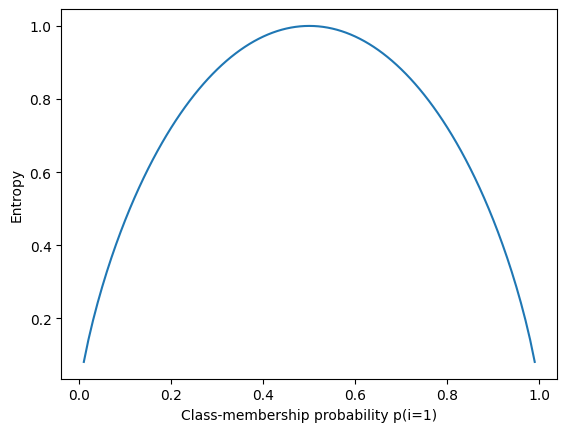

In [1]:
import numpy as np
import matplotlib.pyplot as plt
def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p)) 
x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
plt.ylabel('Entropy')
plt.xlabel('Class-membership probability p(i=1)')
plt.plot(x, ent)
plt.show()

***Impureza Gini*** La impureza de Gini puede entenderse como un criterio para minimizar la probabilidad de clasificación errónea:

$$I_G (t) = \sum_{i=1}^{c}p(i \mid t)(1-p(i\mid t))=1-\sum_{i=1}^{c}p(i\mid t)^{2}$$


***Error de clasificación***


$$I_{E} (t)=1-max(p(i\mid t))$$

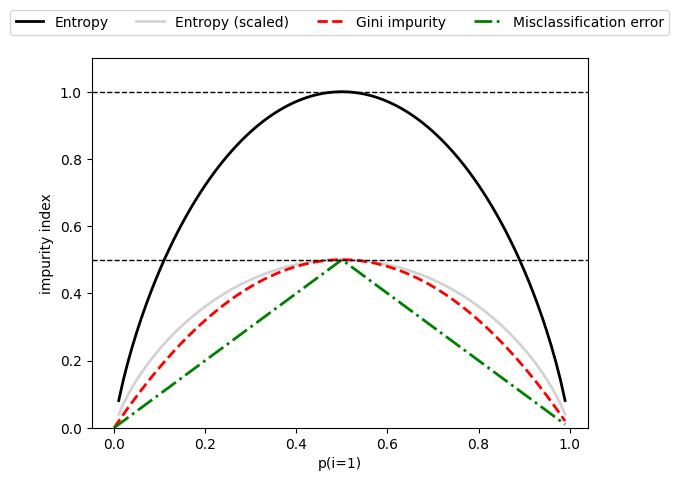

In [2]:
def gini(p):
    return p*(1 - p) + (1 - p)*(1 - (1-p)) 
def entropy(p):
    return - p*np.log2(p) - (1 - p)*np.log2((1 - p)) 
def error(p):
    return 1 - np.max([p, 1 - p])
x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x] 
sc_ent = [e*0.5 if e else None for e in ent]
err = [error(i) for i in x]
fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err],
                            ['Entropy', 'Entropy (scaled)','Gini impurity','Misclassification error'],
                            ["-","-","--","-."],
                            ["black","lightgray","red","green","cyan"]):
    line=ax.plot(x,i,label=lab,linestyle=ls,lw=2,color=c)


ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),ncol=5, fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--') 
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('impurity index')
plt.show()

Para entender los Árboles de Decisión, vamos a construir uno y a echar un vistazo a cómo realiza las predicciones. El siguiente código entrena un DecisionTreeClassifier en el conjunto de datos del iris.

In [9]:
from sklearn.datasets import load_iris # importamos la conocida base de datos Iris
from sklearn.tree import DecisionTreeClassifier, plot_tree # importamos la librería de sklearn
from sklearn.model_selection import train_test_split, cross_val_score
iris = load_iris()
X = iris.data[:, 2:] # tomamos las columna petal length y  width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=40)

In [10]:
y


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

[Text(0.4, 0.8333333333333334, 'petal width (cm) <= 0.8\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]\nclass = setosa'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]\nclass = setosa'),
 Text(0.6, 0.5, 'petal width (cm) <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]\nclass = versicolor'),
 Text(0.4, 0.16666666666666666, 'gini = 0.168\nsamples = 54\nvalue = [0, 49, 5]\nclass = versicolor'),
 Text(0.8, 0.16666666666666666, 'gini = 0.043\nsamples = 46\nvalue = [0, 1, 45]\nclass = virginica')]

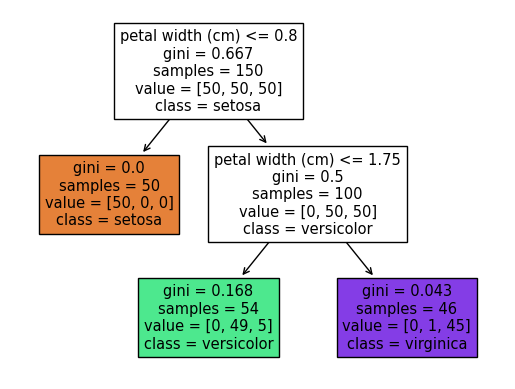

In [11]:
plot_tree(tree_clf, feature_names=iris.feature_names[2:],
class_names=iris.target_names, filled=True)

El atributo de ***samples*** de un nodo cuenta el número de instancias de entrenamiento a las que se aplica. Por ejemplo, 100 instancias de entrenamiento tienen una longitud de pétalo superior a 2,45 cm (profundidad 1, derecha), y de esas 100, 54 tienen una anchura de pétalo inferior a 1,75 cm (profundidad 2, izquierda). El atributo ***value*** de un nodo indica a cuántas instancias de entrenamiento de cada clase se aplica este nodo: por ejemplo, el nodo inferior derecho se aplica a 0 Iris setosa, 1 Iris versicolor y 45 Iris virginica. Por último, el atributo ***gini** de un nodo mide su impureza: un nodo es "puro" (gini=0) si todas las instancias de entrenamiento a las que se aplica pertenecen a la misma clase. Por ejemplo, como el nodo izquierdo de profundidad 1 sólo se aplica a los casos de entrenamiento de Iris setosa, es puro y su puntuación de gini es 0.

Veamos cómo el árbol representado en la Figura anterior hace predicciones. Supongamos que encuentra una flor de iris y quiere clasificarla. Se empieza por el nodo raíz (profundidad 0, en la parte superior): este nodo pregunta si la longitud de los pétalos de la flor es inferior a 2,45 cm. Si lo es, entonces se desplaza hacia abajo hasta el nodo hijo izquierdo de la raíz (profundidad 1, izquierda). En este caso, es un nodo hoja (es decir, no tiene ningún nodo hijo), por lo que no hace ninguna pregunta: simplemente mira la clase predicha para ese nodo, y el Árbol de Decisión predice que su flor es una Iris setosa (clase=setosa).
Ahora suponga que encuentra otra flor, y que esta vez la longitud de los pétalos es superior a 2,45 cm. Debe bajar al nodo hijo derecho de la raíz (profundidad 1, derecha), que no es un nodo hoja, por lo que el nodo hace otra pregunta: ¿es la anchura del pétalo menor de 1,75 cm? Si es así, lo más probable es que su flor sea un Iris versicolor (profundidad 2, izquierda). Si no es así, es probable que sea un Iris virginica
(profundidad 2, derecha). 

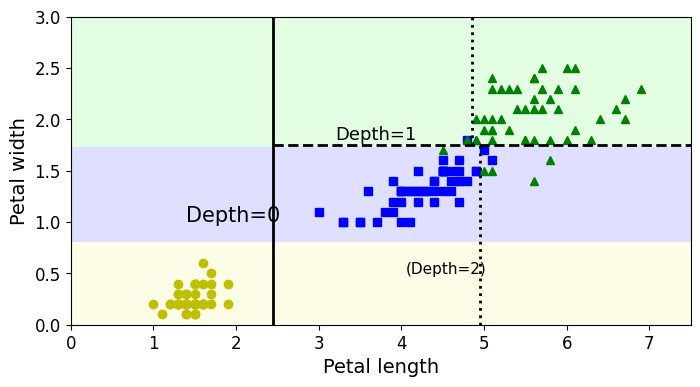

In [12]:
from matplotlib.colors import ListedColormap
import numpy as np
# Costumizar el plot 
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)


plt.show()

Los árboles de decisión son intuitivos y sus decisiones son fáciles de interpretar. Este tipo de modelos suelen denominarse modelos de caja blanca. En cambio, como veremos, los Bosques Aleatorios o las redes neuronales se consideran generalmente modelos de caja negra. Hacen grandes predicciones, y se pueden comprobar fácilmente los cálculos que realizaron para hacer estas predicciones; sin embargo, suele ser difícil explicar en términos sencillos por qué se hicieron las predicciones. Por ejemplo, si una red neuronal dice que una persona concreta aparece en una foto, es difícil saber qué contribuyó a esta predicción: ¿el modelo reconoció los ojos de esa persona? ¿Su boca? ¿Su nariz? ¿Sus zapatos? ¿O incluso el sofá en el que estaba sentada? Por el contrario, los árboles de decisión proporcionan reglas de clasificación sencillas y agradables que pueden incluso aplicarse manualmente si es necesario (por ejemplo, para la clasificación de flores)

Un Árbol de Decisión también puede estimar la probabilidad de que una instancia pertenezca a una determinada clase k. Primero recorre el árbol para encontrar el nodo hoja de esta instancia, y luego devuelve la proporción de instancias de entrenamiento de la clase k en este nodo. Por ejemplo, supongamos que ha encontrado una flor cuyos pétalos miden 5 cm de largo y 1,5 cm de ancho. El nodo de hoja correspondiente es el nodo de profundidad 2 de la izquierda, por lo que el Árbol de Decisión debería arrojar las siguientes probabilidades 0% para Iris setosa (0/54), 90,7% para Iris versicolor (49/54) y 9,3% para Iris virginica (5/54). Y si se le pide que prediga la clase, debería dar como resultado Iris versicolor (clase 1) porque tiene la mayor probabilidad. Comprobemos esto:

## Algoritmo CART


Scikit-Learn utiliza el algoritmo de árbol de clasificación y regresión (CART) para entrenar árboles de decisión (también llamados árboles "crecientes"). El algoritmo funciona dividiendo primero el conjunto de entrenamiento en dos subconjuntos utilizando una única característica k y un umbral t (por ejemplo, "longitud de pétalo ≤ 2,45 cm"). ¿Cómo elige k y t? Busca el par (k, tk) que produce los subconjuntos más puros (ponderados por su tamaño). Función de coste que el algoritmo intenta minimizar.

Una vez que el algoritmo CART ha dividido con éxito el conjunto de entrenamiento en dos, divide los subconjuntos utilizando la misma lógica, luego los sub-conjuntos, y así sucesivamente, de forma recursiva. El algoritmo deja de recursar una vez que alcanza la profundidad máxima (definida por el hiperparámetro max_depth), o si no puede encontrar una división que reduzca la impureza. Otros hiperparámetros (descritos más adelante) controlan otras condiciones de parada (min_samples_split, min_samples_leaf,
min_weight_fraction_leaf, y max_leaf_nodes).

Los árboles de decisión hacen muy pocas suposiciones sobre los datos de entrenamiento (a diferencia de los modelos lineales, que asumen que los datos son lineales, por ejemplo). Si se deja sin restricciones, la estructura del árbol se adaptará a los datos de entrenamiento, ajustándose muy estrechamente a ellos; de hecho, lo más probable es que se sobreajuste. Este modelo suele denominarse no paramétrico, no porque no tenga parámetros (a menudo tiene muchos), sino porque el número de parámetros no se determina antes del entrenamiento, de modo que la estructura del modelo es libre de ajustarse a los datos. En cambio, un modelo paramétrico, como un modelo lineal, tiene un número predeterminado de parámetros, por lo que su grado de libertad es limitado, lo que reduce el riesgo de sobreajuste (pero aumenta el riesgo de subajuste).

En general, el principal problema de los árboles de decisión es que son muy sensibles a las pequeñas variaciones en los datos de entrenamiento. Por ejemplo, si sólo se elimina el Iris versicolor más ancho del conjunto de entrenamiento del iris (el que tiene pétalos de 4,8 cm de largo y 1,8 cm de ancho) y se entrena un nuevo Árbol de Decisión. En realidad, como el algoritmo de entrenamiento utilizado por Scikit-Learn es estocástico, puede obtener modelos muy diferentes incluso con los mismos datos de entrenamiento (a menos que configure el hiperparámetro random_state). Observe los resultados de la nueva división apenas modificando la semilla del árbol. 

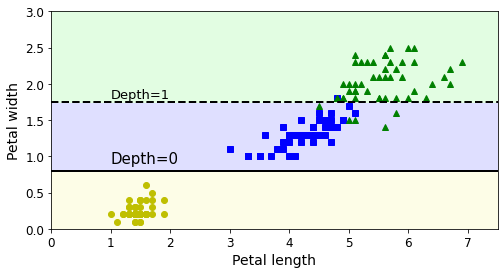

In [ ]:
tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X, y)
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X, y, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)


plt.show()

Para evitar el sobreajuste de los datos de entrenamiento, es necesario restringir el grado de libertad del árbol de decisión durante el entrenamiento. Como ya sabe, esto se llama regularización. Los hiperparámetros de regularización dependen del algoritmo utilizado, pero generalmente se puede restringir al menos la profundidad máxima del Árbol de Decisión. En Scikit-Learn, esto se controla con el hiperparámetro max_depth (el valor por defecto es None, que significa ilimitado). La reducción de max_depth regularizará el modelo y, por tanto, reducirá el riesgo de sobreajuste.

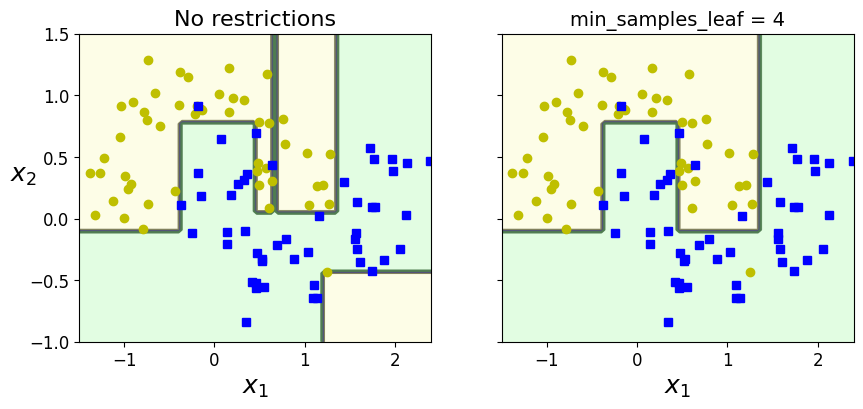

In [20]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")


plt.show()

## Regresión


In [ ]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)
y_pred = tree_reg.predict(X)

[Text(0.5, 0.8333333333333334, 'X[0] <= 0.197\nsquared_error = 0.098\nsamples = 200\nvalue = 0.354'),
 Text(0.25, 0.5, 'X[0] <= 0.092\nsquared_error = 0.038\nsamples = 44\nvalue = 0.689'),
 Text(0.125, 0.16666666666666666, 'squared_error = 0.018\nsamples = 20\nvalue = 0.854'),
 Text(0.375, 0.16666666666666666, 'squared_error = 0.013\nsamples = 24\nvalue = 0.552'),
 Text(0.75, 0.5, 'X[0] <= 0.772\nsquared_error = 0.074\nsamples = 156\nvalue = 0.259'),
 Text(0.625, 0.16666666666666666, 'squared_error = 0.015\nsamples = 110\nvalue = 0.111'),
 Text(0.875, 0.16666666666666666, 'squared_error = 0.036\nsamples = 46\nvalue = 0.615')]

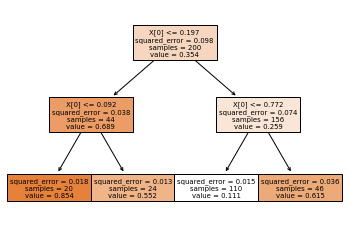

In [ ]:
plot_tree(tree_reg, filled=True)

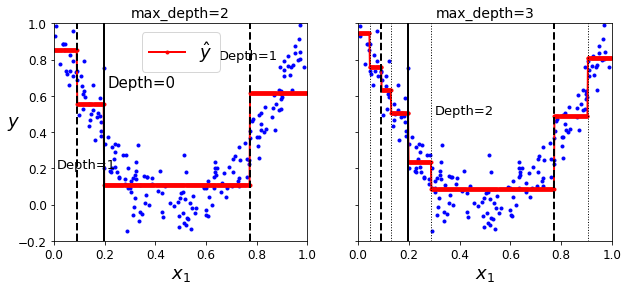

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)


plt.show()

[Text(0.5, 0.875, 'X[0] <= 0.197\nsquared_error = 0.098\nsamples = 200\nvalue = 0.354'),
 Text(0.25, 0.625, 'X[0] <= 0.092\nsquared_error = 0.038\nsamples = 44\nvalue = 0.689'),
 Text(0.125, 0.375, 'X[0] <= 0.046\nsquared_error = 0.018\nsamples = 20\nvalue = 0.854'),
 Text(0.0625, 0.125, 'squared_error = 0.012\nsamples = 10\nvalue = 0.947'),
 Text(0.1875, 0.125, 'squared_error = 0.006\nsamples = 10\nvalue = 0.761'),
 Text(0.375, 0.375, 'X[0] <= 0.13\nsquared_error = 0.013\nsamples = 24\nvalue = 0.552'),
 Text(0.3125, 0.125, 'squared_error = 0.007\nsamples = 9\nvalue = 0.633'),
 Text(0.4375, 0.125, 'squared_error = 0.01\nsamples = 15\nvalue = 0.504'),
 Text(0.75, 0.625, 'X[0] <= 0.772\nsquared_error = 0.074\nsamples = 156\nvalue = 0.259'),
 Text(0.625, 0.375, 'X[0] <= 0.287\nsquared_error = 0.015\nsamples = 110\nvalue = 0.111'),
 Text(0.5625, 0.125, 'squared_error = 0.006\nsamples = 19\nvalue = 0.236'),
 Text(0.6875, 0.125, 'squared_error = 0.013\nsamples = 91\nvalue = 0.084'),
 Text(0.

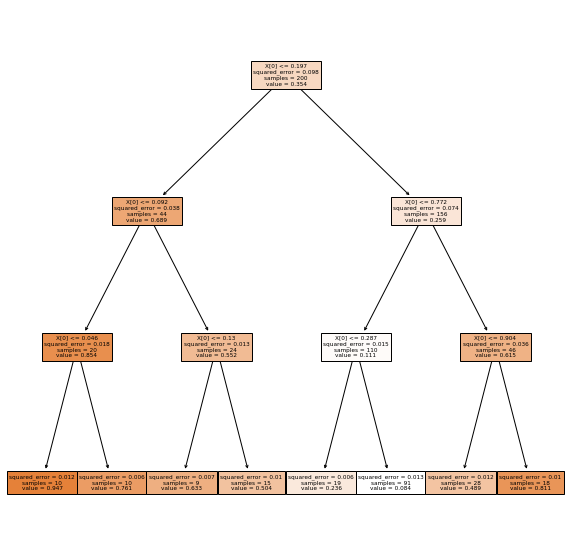

In [ ]:
figura, eixos = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
plot_tree(tree_reg2, filled=True)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9e39fdd9-54f0-47f6-b432-6e1ff9973ce7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>